## Quantitative QC by CV calculation
The data used in this notebook is lymphocyte data for one patient's B cells and T cells. We use this data to show the proteome variation between the cell types. Here, we calculate CVs to show the quality of the data.

After calculating CVs, we calculate Spearman correlation among replicates.


First, we import our loader module. This brings the functions defined there (in our repository at ~/load_data.py) into scope so we can use them in this script. Then we can load our data and store it as <code>data</code>.

Calling <code>head</code> shows the first several lines of the dataframe, which provides an idea of the type of data present and the structure of the dataframe.

In [1]:
import load_data
data_raw = load_data.load_FragPipe(month="lymph_forPRIDE")
#data_raw=load_data.load_max_quant()
data_raw.head()

,Subject1_FACS145_B_C10,Subject1_FACS145_B_C11,Subject1_FACS145_B_C12,Subject1_FACS145_B_C13,Subject1_FACS145_B_C9,Subject1_FACS145_T_D10,Subject1_FACS145_T_D11,Subject1_FACS145_T_D12,Subject1_FACS145_T_D13,Subject1_FACS145_T_D9
Protein ID,,,,,,,,,,
A0A0B4J2D5,887620.10,1370180.1,2062984.60,2450476.00,1365915.2,328929.3,361140.16,186872.61,0.00,202940.38
A0AVT1,436741.90,703239.6,862428.60,418775.84,1720851.8,0.0,586732.06,0.00,0.00,317229.88
A0FGR8,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00
A6NHR9,164891.88,0.0,0.00,0.00,0.0,0.0,0.00,0.00,436801.84,0.00
A8MWD9,520638.70,1043206.2,703606.44,1145135.20,465469.2,0.0,465638.90,0.00,0.00,339949.03


Now we normalize across runs. Note that following median normalization, we reverse the log2, leaving the data aligned between runs but allowing the most typical coefficient variation calculation.

In [2]:
import data_utils
data_log2_normalized = data_utils.normalize(data_raw)
data_normalized = data_log2_normalized.apply(lambda series: 2**series)

Next, we select the proteins that are measured in at least three samples from each group, allowing the calculations to proceed without imputed zero-handling.

In [3]:
import data_utils    
cell_types = ['B_', 'T_']
indecies = data_normalized.apply(data_utils.check_three_of_each_type, axis=1,
                      cell_types = cell_types)
data = data_normalized[indecies]
data.head()

,Subject1_FACS145_B_C10,Subject1_FACS145_B_C11,Subject1_FACS145_B_C12,Subject1_FACS145_B_C13,Subject1_FACS145_B_C9,Subject1_FACS145_T_D10,Subject1_FACS145_T_D11,Subject1_FACS145_T_D12,Subject1_FACS145_T_D13,Subject1_FACS145_T_D9
Protein ID,,,,,,,,,,
A0A0B4J2D5,0.632290,0.799103,1.498127,1.263520,0.872645,0.205904,0.275353,0.123126,NaN,0.144223
B5ME19,0.543397,0.607015,0.460605,0.340988,0.231616,0.236722,0.616410,0.401453,0.685667,0.533683
O00148,4.804527,4.550815,5.511116,3.434922,3.532960,4.414555,4.249327,4.517552,4.308691,3.785516
O00151,1.412252,1.373957,1.505986,1.192610,1.317748,NaN,NaN,0.118827,0.237478,0.265731
O00170,0.366428,0.183391,0.392998,NaN,NaN,0.314262,0.298095,0.469659,0.336940,0.359179


Finally, we will calculate the coeffients of variation for each protein within each of the two cell types. 

In [4]:
from scipy.stats import variation
from statistics import mean
import pandas as pd
from numpy import isnan

In [5]:
CVs = {}
for population in cell_types:
    cells_in_population = list(s for s in data.columns.values.tolist() if population in s)
    data_by_type = data[cells_in_population]
    #now we have a dataframe with just one subpopulation
    #Call variation function
    var = data_by_type.apply(variation, axis=1, nan_policy='omit')
    CVs[population] = var
    
    #Here we report an overview
    print (population)
    print ('Mean CV:\t',mean(var))
    print ('Min CV: \t',min(var))
    print ('Max CV: \t',max(var))
    print ('nan:    \t',len([i for i in var if isnan(i)]))
    print ('Zero:    \t',len([i for i in var if i==0]))
    var_under_20 = len([i for i in var if i < .2])
    var_under_10 = len([i for i in var if i < .1])
    count = len(var)#len([i for i in var if i!=0])
    print ('Under 10%:\t',var_under_10,'\t{0:.2f}'.format(var_under_10/count))
    print ('Under 20%:\t',var_under_20,'\t{0:.2f}'.format(var_under_20/count))
    print (count)
    print ()
    

CVs = pd.DataFrame.from_dict(CVs)    

B_
Mean CV:	 0.3088778371436992
Min CV: 	 0.021429304111037183
Max CV: 	 1.2714695310673685
nan:    	 0
Zero:    	 0
Under 10%:	 48 	0.05
Under 20%:	 375 	0.39
960

T_
Mean CV:	 0.25295331490806006
Min CV: 	 0.019225225484385145
Max CV: 	 1.853541063002322
nan:    	 0
Zero:    	 0
Under 10%:	 159 	0.17
Under 20%:	 520 	0.54
960



Next, we will visualize the data, which shows that the majority of proteins have small coefficients of variation.

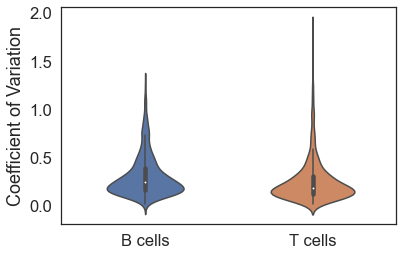

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)
sns.set_style("white")
figure = sns.violinplot(data=CVs, width=.5)
figure.set_ylabel("Coefficient of Variation")
figure.set_xticklabels(['B cells', 'T cells'])
plt.savefig("data/figures/CV.png", dpi=300)

plt.show()

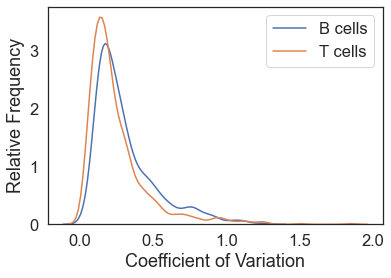

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.5)

sns.set_style("white")
figure = sns.distplot(CVs['B_'], hist = False, label='B cells')#, width=.5)
figure = sns.distplot(CVs['T_'], hist = False, label='T cells')#, width=.5)
figure.set_ylabel("Relative Frequency")
figure.set_xlabel("Coefficient of Variation")

figure.legend(['B cells', 'T cells'])
plt.savefig("data/figures/qc_hist.png", dpi=300,
            bbox_inches='tight')
plt.show()

Here we summarize the CVs overall. Note that the CVs were calculated within types and so still represent technical variability, not variation between cell types.

In [8]:
var = CVs.values.flatten()

print ('Mean CV:\t',mean(var))
print ('Min CV: \t',min(var))
print ('Max CV: \t',max(var))
print ('nan:    \t',len([i for i in var if isnan(i)]))
print ('Zero:    \t',len([i for i in var if i==0]))
    
var_under_20 = len([i for i in var if i < .2])
var_under_10 = len([i for i in var if i < .1])
count = len(var)#len([i for i in var if i!=0])
print ('Under 10%:\t',var_under_10,'\t{0:.2f}'.format(var_under_10/count))
print ('Under 20%:\t',var_under_20,'\t{0:.2f}'.format(var_under_20/count))

Mean CV:	 0.28091557602587963
Min CV: 	 0.019225225484385145
Max CV: 	 1.853541063002322
nan:    	 0
Zero:    	 0
Under 10%:	 207 	0.11
Under 20%:	 895 	0.47


This shows accuracy in repeatedly characterizing each cell type.

### Correlation coefficient
Next, we show reproducibility of the replicates by Spearman correlation coefficient.

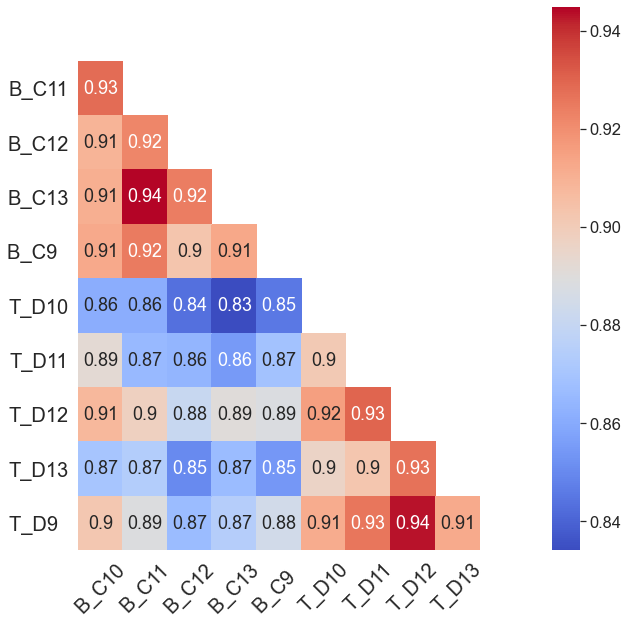

In [9]:
correlations = data.corr(method="spearman")

ylabels=[' ','B_C11','B_C12','B_C13','B_C9  ',
        'T_D10','T_D11','T_D12','T_D13','T_D9  ']


xlabels=['B_C10','B_C11','B_C12','B_C13','B_C9  ',
        'T_D10','T_D11','T_D12','T_D13','  ']

correlations.index=ylabels
correlations.columns=xlabels

import numpy as np
mask = np.zeros(correlations.shape, dtype=bool)
mask[np.triu_indices(len(mask))] = True

plt.figure(figsize=(10,10)) 
fig =sns.heatmap(correlations, cmap = 'coolwarm', mask = mask, annot=True)

plt.yticks(rotation=0, size=20) 
plt.xticks(rotation=45, size = 20)


plt.savefig("data/AutoPOTS_forPRIDE/correlations_lymph.png", dpi=300,
            bbox_inches='tight')

In [10]:
from numpy import nan
#drop self-correlations of 1
for sample in correlations.columns:
        correlations[sample][sample]=nan
        
correlations

,B_C10,B_C11,B_C12,B_C13,B_C9,T_D10,T_D11,T_D12,T_D13,
,1.000000,0.928195,0.908959,0.910817,0.912788,0.861031,0.892402,0.907839,0.870308,0.902355
B_C11,0.928195,NaN,0.922231,0.944874,0.924768,0.861124,0.865290,0.897916,0.874283,0.888869
B_C12,0.908959,0.922231,NaN,0.924249,0.903204,0.843536,0.863656,0.880994,0.850093,0.866254
B_C13,0.910817,0.944874,0.924249,NaN,0.913176,0.834051,0.855229,0.890715,0.866408,0.874513
B_C9,0.912788,0.924768,0.903204,0.913176,NaN,0.845362,0.869054,0.888468,0.854034,0.884401
T_D10,0.861031,0.861124,0.843536,0.834051,0.845362,NaN,0.901199,0.915850,0.896282,0.911656
T_D11,0.892402,0.865290,0.863656,0.855229,0.869054,0.901199,NaN,0.930088,0.902657,0.925850
T_D12,0.907839,0.897916,0.880994,0.890715,0.888468,0.915850,0.930088,NaN,0.926990,0.943316
T_D13,0.870308,0.874283,0.850093,0.866408,0.854034,0.896282,0.902657,0.926990,NaN,0.912237
T_D9,0.902355,0.888869,0.866254,0.874513,0.884401,0.911656,0.925850,0.943316,0.912237,1.000000


Here we split the dataset by cell type and perform the same correlation test. We then take the average correlation between replicates.

In [11]:
from numpy import nan

corr_type = {}
corr_summary={}
for cell_type in cell_types:
    
    cells_of_type = list(s for s in data.columns.values.tolist() if cell_type in s)
    data_by_type = data[cells_of_type]
    corr_of_type = data_by_type.corr(method='spearman')
    
    #drop self-correlations of 1
    for sample in corr_of_type.columns:
        corr_of_type[sample][sample]=nan
    
    corr_type[cell_type] = corr_of_type
    
    #take the average of the correlations between a sample and  
    #    the other samples of the same type
    summary = corr_of_type.apply(lambda x: mean(x.dropna()))
    corr_summary[cell_type] = mean(summary)
    
    print (cell_type,"average correlation:\t",mean(summary))

B_ average correlation:	 0.9193260745109654
T_ average correlation:	 0.9166125500087751


With the average correlation between each set of replicates, we now average them to get the overall average. 

In [12]:
mean(corr_summary.values())

0.9179693122598702

Now, we calculate the average correlation when comparing a B cell replicate to a T cell replicate. We expect this to be lower than either of the two above numbers comparing replicates within a cell type.

In [13]:
B_cells = list(s for s in correlations.index if 'B_' in s)
T_cells = list(s for s in correlations.index if 'T_' in s)

corr_cross_types = []

for B in B_cells:
    for T in T_cells:
        c = correlations[B][T]
        corr_cross_types.append(c)
        
print("Mean cross-type correlations:")        
mean(corr_cross_types)

Mean cross-type correlations:


0.8677125404030437